In [1]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import hdf5getters as GETTERS
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.35:7077") \
        .appName("r")\
        .config("spark.executor.cores",2)\
        .config("spark.dynamicAllocation.enabled", False) \
        .config("spark.shuffle.service.enabled", False) \
        .getOrCreate()
        
sc = spark_session.sparkContext

In [5]:
#from hdfs import HDFileSystem
#hdfs = HDFileSystem()
#import pydoop.hdfs

#msd_subset_path='/home/ubuntu/MillionSongSubset/'
msd_subset_path='hdfs://192.168.2.35:9000/A/'
#msd_subset_data_path=os.path.join(msd_subset_path,'data')
#msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
#msd_code_path='/home/ubuntu/MSongsDB'
msd_code_path='/home/ubuntu/MSongsDB'
dbfile = '/home/ubuntu/MSongsDB/Tasks_Demos/SQLite/track_metadata.db'
sys.path.append(os.path.join(msd_code_path,'PythonSrc'))

def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
        for f in files :
            func(f)       
    return cnt

print('number of song files:',apply_to_all_files(msd_subset_path))

number of song files: 0


In [6]:
#msd_subset_path='hdfs://192.168.2.35:9000/data/'

A_list = ["A", "B","C","D","E","F","G","H","I","J","K","L","M","N","O", "P","Q", "R","S", "T","U","V","W","X","Y","Z"]
#A_list = ["A", "B"]
all_paths = ""
i = 0
for letter in A_list:
    path = "hdfs://192.168.2.35:9000/A/A/A/" + letter + "/*" 
    if i == 0:
        all_paths = path
        i += 1
    else:
        all_paths = all_paths + "," + path
    
print(all_paths)
#files = sc.binaryFiles(all_paths).cache()
files = sc.binaryFiles(all_paths)


hdfs://192.168.2.35:9000/A/A/A/A/*,hdfs://192.168.2.35:9000/A/A/A/B/*,hdfs://192.168.2.35:9000/A/A/A/C/*,hdfs://192.168.2.35:9000/A/A/A/D/*,hdfs://192.168.2.35:9000/A/A/A/E/*,hdfs://192.168.2.35:9000/A/A/A/F/*,hdfs://192.168.2.35:9000/A/A/A/G/*,hdfs://192.168.2.35:9000/A/A/A/H/*,hdfs://192.168.2.35:9000/A/A/A/I/*,hdfs://192.168.2.35:9000/A/A/A/J/*,hdfs://192.168.2.35:9000/A/A/A/K/*,hdfs://192.168.2.35:9000/A/A/A/L/*,hdfs://192.168.2.35:9000/A/A/A/M/*,hdfs://192.168.2.35:9000/A/A/A/N/*,hdfs://192.168.2.35:9000/A/A/A/O/*,hdfs://192.168.2.35:9000/A/A/A/P/*,hdfs://192.168.2.35:9000/A/A/A/Q/*,hdfs://192.168.2.35:9000/A/A/A/R/*,hdfs://192.168.2.35:9000/A/A/A/S/*,hdfs://192.168.2.35:9000/A/A/A/T/*,hdfs://192.168.2.35:9000/A/A/A/U/*,hdfs://192.168.2.35:9000/A/A/A/V/*,hdfs://192.168.2.35:9000/A/A/A/W/*,hdfs://192.168.2.35:9000/A/A/A/X/*,hdfs://192.168.2.35:9000/A/A/A/Y/*,hdfs://192.168.2.35:9000/A/A/A/Z/*


In [3]:
files = sc.binaryFiles("hdfs://192.168.2.35:9000/A/A/A/*")


In [7]:
#rdd1 = files.take(5)
#fileRDD = files.map(lambda x: GETTERS.get_year(x)) 

In [2]:
import io
import h5py
import math
import attr
def get_year(h5):   
    return int(h5["musicbrainz"]["songs"][0][1])

def artist_hotness(h5):
    x = float(h5["metadata"]["songs"][0][3])
    if math.isnan(x):
        return 0.0
    else:
        return x
def song_hotness(h5):
    x =  float(h5["metadata"]["songs"][0][16])
    if math.isnan(x):
        return 0.0
    else:
        return x
def loudness(h5):
    x = float(h5["analysis"]["songs"][0][23])
    if math.isnan(x):
        return 0.0
    else:
        return x
def tempo(h5):
    x = float(h5["analysis"]["songs"][0][27])
    if math.isnan(x):
        return 0.0
    else:
        return x


def f(tup):
    _path, data = tup
    with io.BytesIO(data) as b, h5py.File(b, "r") as f:
        return get_year(f), artist_hotness(f), song_hotness(f), loudness(f), tempo(f)
        #return list(f["analysis"]["songs"].attrs.items())

In [9]:
#files.take(1)
rdd2 = files.map(lambda x: f(x))


In [3]:
#rdd2.take(5)
h5py.run_tests()

0

In [16]:
rdd3 = rdd2.filter(lambda x: len(x) == 6)\
    .filter(lambda x: type(x[0]) == int and x[0] >= 1980)\
    .filter(lambda x: x[1] > 0)

In [4]:
all_the_info = set()

def func_to_get_all_the_info(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    year = GETTERS.get_year(h5)
    hotness = GETTERS.get_song_hotttnesss(h5)
    artist_hotness = GETTERS.get_artist_hotttnesss(h5)
    loudness = GETTERS.get_loudness(h5)
    tempo = GETTERS.get_tempo(h5)
    key = GETTERS.get_key(h5)
    
    all_the_info.add((year, hotness, artist_hotness, loudness, tempo, key))
    h5.close()

apply_to_all_files(msd_subset_data_path,func=func_to_get_all_the_info)

10000

In [5]:
rdd = sc.parallelize(list(all_the_info))
rdd1 = rdd.map(lambda x: list(x)).map(lambda y: ([int(y[0]), y[1], y[2], y[3], y[4], y[5]]))
rdd2 = rdd1.filter(lambda x: len(x) == 6)\
    .filter(lambda x: type(x[0]) == int and x[0] >= 1980)\
    .filter(lambda x: x[1] > 0)
rdd3 = rdd2.map(lambda x: (x[0], [x[1], x[2], x[3], x[4], x[5], 1]))

In [6]:
rdd4 = rdd3.reduceByKey(lambda a,b: [a[0]+b[0], a[1]+b[1], a[2]+b[2], a[3]+b[3], a[4]+b[4], a[5]+b[5]])\
    .map(lambda x: (x[0], [x[1][0]/x[1][5], x[1][1]/x[1][5], x[1][2]/x[1][5], x[1][3]/x[1][5], x[1][4]/x[1][5]]))
rdd4.cache()

PythonRDD[5] at RDD at PythonRDD.scala:53

In [7]:
import math

def sigmoid(alist):
    listMax = float(max(alist))
    alist = [i/listMax for i in alist]
    alist = [1/(1+math.exp(-i)) for i in alist]
    return alist

time = sorted(rdd4.map(lambda x: x[0]).collect())
song_hotness = sigmoid(sorted(rdd4.map(lambda x: x[1][0]).collect()))
artist_hotness = sigmoid(sorted(rdd4.map(lambda x: x[1][1]).collect()))
loudness = sigmoid(sorted(rdd4.map(lambda x: x[1][2]).collect()))
tempo = sigmoid(sorted(rdd4.map(lambda x: x[1][3]).collect()))

In [17]:
from pyspark.mllib.stat import Statistics

rdd_song_hotness = rdd3.map(lambda x: x[1])
rdd_artist_hotness = rdd3.map(lambda x: x[2])
rdd_loudness = rdd3.map(lambda x: x[3])
rdd_tempo = rdd3.map(lambda x: x[4])

corr_artist = Statistics.corr(rdd_song_hotness, rdd_artist_hotness, method="pearson")
corr_loudness = Statistics.corr(rdd_song_hotness, rdd_loudness, method="pearson")
corr_tempo = Statistics.corr(rdd_song_hotness, rdd_tempo, method="pearson")

print("Correlation song hotness and artist hotness: ", corr_artist,
"\nCorrelation song hotness and loudness: ", corr_loudness,
"\nCorrelation song hotness and tempo: ", corr_tempo)

Py4JJavaError: An error occurred while calling o366.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 7.0 failed 4 times, most recent failure: Lost task 1.3 in stage 7.0 (TID 44, 192.168.2.94, executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 579, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 700, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 1110, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'h5py'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:484)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:619)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:602)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:437)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at org.apache.spark.rdd.RDD$$anon$2.hasNext(RDD.scala:925)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:266)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1423)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2156)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:441)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:444)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:1989)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1977)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1976)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1976)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:956)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2155)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2144)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:758)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2116)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2137)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2156)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1423)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1396)
	at org.apache.spark.rdd.RDD.$anonfun$first$1(RDD.scala:1437)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1437)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.numCols(RowMatrix.scala:62)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:433)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlation.computeCorrelationWithMatrixImpl(Correlation.scala:46)
	at org.apache.spark.mllib.stat.correlation.Correlation.computeCorrelationWithMatrixImpl$(Correlation.scala:44)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationWithMatrixImpl(PearsonCorrelation.scala:34)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelation(PearsonCorrelation.scala:40)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corr(Correlation.scala:60)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:112)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.corr(PythonMLLibAPI.scala:845)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 579, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 700, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 1110, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'h5py'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:484)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:619)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:602)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:437)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at org.apache.spark.rdd.RDD$$anon$2.hasNext(RDD.scala:925)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:266)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1423)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2156)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:441)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:444)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [11]:
list_song_hot = rdd2.map(lambda x: x[1]).collect()
#print(list_song_hot[0])

list_artist_hot = rdd2.map(lambda x: x[2]).collect()
print(list_artist_hot[0])
#list_loudness = rdd2.map(lambda x: x[3]).collect()
#print(list_loudness[0])

list_tempo = rdd2.map(lambda x: x[4]).collect()
print(list_tempo[0])


from scipy.stats import pearsonr
pearson_corr1, p_value1 = pearsonr(list_song_hot, list_artist_hot)
#pearson_corr2, p_value2 = pearsonr(list_song_hot, list_loudness)
pearson_corr3, p_value3 = pearsonr(list_song_hot, list_tempo)

print('Compared attribute             Pearson correlation coefficient    p-value')
print(f'Song hotness vs artist hotness {pearson_corr1}                {p_value1}')
#print(f'Song hotness vs loudness       {pearson_corr2}                {p_value2}')
print(f'Song hotness vs tempo          {pearson_corr3}                {p_value3}')


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 4 times, most recent failure: Lost task 0.3 in stage 1.0 (TID 10, 192.168.2.94, executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 579, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 700, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 1110, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'h5py'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:484)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:619)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:602)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:437)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1004)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2156)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:441)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:444)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:1989)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1977)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1976)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1976)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:956)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2155)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2144)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:758)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2116)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2137)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2156)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2181)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:168)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 579, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 700, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/cloudpickle.py", line 1110, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'h5py'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:484)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:619)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:602)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:437)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1004)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2156)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:441)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:444)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [10]:
import matplotlib.pyplot as plt
plt.scatter(rdd_song_hotness.collect(), rdd_artist_hotness.collect(), alpha=0.5)
plt.title('Song and Artist Hotness')
plt.xlabel('Song Hotness')
plt.ylabel('Artist Hotness')
plt.show()

<Figure size 640x480 with 1 Axes>

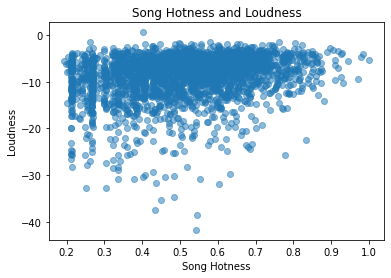

In [11]:
plt.scatter(rdd_song_hotness.collect(), rdd_loudness.collect(), alpha=0.5)
plt.title('Song Hotness and Loudness')
plt.xlabel('Song Hotness')
plt.ylabel('Loudness')
plt.show()

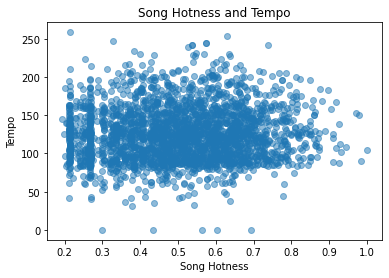

In [12]:
plt.scatter(rdd_song_hotness.collect(), rdd_tempo.collect(), alpha=0.5)
plt.title('Song Hotness and Tempo')
plt.xlabel('Song Hotness')
plt.ylabel('Tempo')
plt.show()

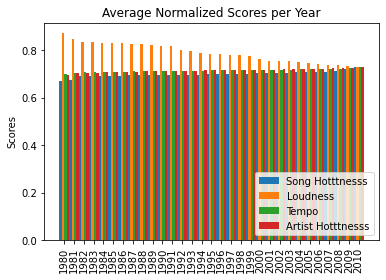

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(time))
width = 1

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/8, song_hotness, width/4, label='Song Hotttnesss')
rects3 = ax.bar(x - width/8, loudness, width/4, label='Loudness')
rects4 = ax.bar(x + width/8, tempo, width/4, label='Tempo')
rects2 = ax.bar(x + 3*width/8, artist_hotness, width/4, label='Artist Hotttnesss')

ax.set_ylabel('Scores')
ax.set_title('Average Normalized Scores per Year')
ax.set_xticks(x)
ax.set_xticklabels(time, rotation = 90)

ax.legend(loc = 'lower right')

plt.show()


In [2]:
sc.stop()